<a href="https://colab.research.google.com/github/AnnyNny/population_classification/blob/main/Russian_population_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import pandas
import zipfile
import urllib.request
import plotnine
from subprocess import Popen

In [2]:
data_dir = "data"
os.makedirs(data_dir, exist_ok=True)

## Data Loading

### Archive data link

In [3]:
data_url = "http://www.russiangenome.ru/biengi.zip"
data_zip = os.path.join(data_dir, "plink_data.zip")

urllib.request.urlretrieve(data_url, data_zip)

('data/plink_data.zip', <http.client.HTTPMessage at 0x7ec6d1834aa0>)

In [4]:
with zipfile.ZipFile(data_zip, 'r') as zipped_datafile:
    zipped_datafile.extractall(data_dir)

### Path to the data

In [5]:
data_prefix = [os.path.splitext(os.path.join(data_dir, file))[0] for file in os.listdir(data_dir) if file.endswith('.bed')][0]

## Download plink

In [6]:
%%bash
URL64BIT="http://s3.amazonaws.com/plink1-assets/plink_linux_x86_64_20200121.zip"
URL32BIT="http://s3.amazonaws.com/plink1-assets/plink_linux_i686_20200121.zip"

URL=$URL64BIT

wget -q $URL -O plink.zip
unzip -q -n plink.zip plink

## Functions for plink

In [7]:
def prune_data(plink_prefix, out_prefix):
    cmd = ['./plink', '--bfile', plink_prefix,
           '--indep', '50', '5', '2', '--out', out_prefix
    ]
    prune_result = out_prefix + '.prune.in'
    assert Popen(cmd).wait() == 0

    cmd = ['./plink', '--bfile', plink_prefix, '--extract', prune_result,
           '--make-bed', '--out', out_prefix
    ]
    assert Popen(cmd).wait() == 0

    return

def pca_plink(plink_prefix, out_prefix, n_components=20):
    # Perform PCA using plink
    cmd = ['./plink', '--pca', str(n_components), '--autosome']
    cmd += ['--bfile', plink_prefix, '--out', out_prefix]

    assert Popen(cmd).wait() == 0

    return out_prefix + '.eigenvec', out_prefix + '.eigenval'


## Pruning

In [8]:
pruned_data = data_prefix + '_pruned'
prune_data(data_prefix, pruned_data)

## PCA

In [9]:
pca_prefix = pruned_data + '_pruned'
pca_eigenvec, pca_eigenval = pca_plink(pruned_data, pca_prefix)

### Reading dependant variable (Population)

In [10]:
pop_filename = data_prefix + ".pedind"
pop_df = pandas.read_csv(pop_filename, sep="\s+", header=None, usecols = [0, 1, 5],
                        names=['FID', 'IID', 'Population'])

pop_df.head()

<>:2: SyntaxWarning: invalid escape sequence '\s'
<>:2: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-1471873661.py:2: SyntaxWarning: invalid escape sequence '\s'


,FID,IID,Population
0,4461875510_R01C01,4461875510_R01C01,Karel
1,4461875510_R01C02,4461875510_R01C02,Karel
2,4461875510_R02C01,4461875510_R02C01,Karel
3,4461875513_R02C02,4461875513_R02C02,Karel
4,4461875513_R01C02,4461875513_R01C02,Karel


### Reading PCA features

In [24]:
eigenvec_df = pandas.read_csv(pca_eigenvec, sep="\s+", header=None)
n_cols = eigenvec_df.shape[1]
pc_cols = [f"PC{i}" for i in range(1, n_cols-1)]
eigenvec_df.columns = ['FID', 'IID'] + pc_cols
eigenvec_df.head()

<>:1: SyntaxWarning: invalid escape sequence '\s'
<>:1: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-3171394871.py:1: SyntaxWarning: invalid escape sequence '\s'


,FID,IID,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,...,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20
0,4461875510_R01C01,4461875510_R01C01,0.023656,0.044685,0.024901,-0.012835,-0.009770,0.006716,-0.010370,0.006021,...,0.005069,0.051467,-0.010690,-0.035015,-0.095092,0.014845,-0.033535,-0.013700,0.036779,0.001613
1,4461875510_R01C02,4461875510_R01C02,0.029982,0.033608,0.032103,-0.014175,-0.004904,0.022838,-0.003047,0.004947,...,-0.004695,-0.001433,-0.029270,-0.019349,-0.020024,-0.011725,0.016307,0.008480,-0.009798,0.005745
2,4461875510_R02C01,4461875510_R02C01,0.025548,0.043980,0.023810,-0.012104,-0.004047,0.016872,-0.007012,0.017078,...,-0.000110,0.040661,-0.025415,-0.024280,-0.135829,0.018732,-0.032434,-0.039587,0.028321,0.034078
3,4461875513_R02C02,4461875513_R02C02,0.022953,0.045839,0.024924,-0.015718,-0.011845,0.007434,-0.018396,0.024504,...,-0.013387,0.026770,-0.036955,-0.028485,-0.125899,0.049872,-0.016697,-0.007108,0.016528,0.005287
4,4461875513_R01C02,4461875513_R01C02,0.024415,0.043405,0.018632,-0.004825,-0.007012,0.008693,-0.011580,0.011086,...,0.013590,0.035081,-0.020707,-0.024508,-0.139401,0.012883,-0.033515,-0.008684,0.042671,-0.008286


In [26]:
print(pop_df.columns)
pop_df.head()


Index(['FID', 'IID', 'Population'], dtype='object')


,FID,IID,Population
0,4461875510_R01C01,4461875510_R01C01,Karel
1,4461875510_R01C02,4461875510_R01C02,Karel
2,4461875510_R02C01,4461875510_R02C01,Karel
3,4461875513_R02C02,4461875513_R02C02,Karel
4,4461875513_R01C02,4461875513_R01C02,Karel


In [32]:
merge_df = pandas.merge(eigenvec_df, pop_df, left_on=['FID', 'IID'], right_on=['FID', 'IID'])
merge_df.head()

,FID,IID,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,...,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,Population
0,4461875510_R01C01,4461875510_R01C01,0.023656,0.044685,0.024901,-0.012835,-0.009770,0.006716,-0.010370,0.006021,...,0.051467,-0.010690,-0.035015,-0.095092,0.014845,-0.033535,-0.013700,0.036779,0.001613,Karel
1,4461875510_R01C02,4461875510_R01C02,0.029982,0.033608,0.032103,-0.014175,-0.004904,0.022838,-0.003047,0.004947,...,-0.001433,-0.029270,-0.019349,-0.020024,-0.011725,0.016307,0.008480,-0.009798,0.005745,Karel
2,4461875510_R02C01,4461875510_R02C01,0.025548,0.043980,0.023810,-0.012104,-0.004047,0.016872,-0.007012,0.017078,...,0.040661,-0.025415,-0.024280,-0.135829,0.018732,-0.032434,-0.039587,0.028321,0.034078,Karel
3,4461875513_R02C02,4461875513_R02C02,0.022953,0.045839,0.024924,-0.015718,-0.011845,0.007434,-0.018396,0.024504,...,0.026770,-0.036955,-0.028485,-0.125899,0.049872,-0.016697,-0.007108,0.016528,0.005287,Karel
4,4461875513_R01C02,4461875513_R01C02,0.024415,0.043405,0.018632,-0.004825,-0.007012,0.008693,-0.011580,0.011086,...,0.035081,-0.020707,-0.024508,-0.139401,0.012883,-0.033515,-0.008684,0.042671,-0.008286,Karel


In [37]:
df = merge_df.copy()

In [38]:
df.shape

(894, 23)

In [39]:
print("Unique groups:", len(df["Population"].unique()))
display(df["Population"].value_counts().head(30))

Unique groups: 28


,count
Population,
Kazakh,45
Tuva,44
Buryat,44
Yakut,41
Russian_STV,39
Uzbek,39
Russian_NSK,38
Megrel,36
Kabardin,35


In [40]:
group_means = df.groupby("Population")[pc_cols].mean()
group_means.head()


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20
Population,,,,,,,,,,,,,,,,,,,,
Abkhaz,0.031622,-0.058212,-0.025333,0.001820,-0.009293,0.000351,-0.008472,0.005862,-0.007090,-0.001388,-0.001996,0.018928,-0.012499,0.003979,0.000028,0.005199,-0.048195,0.012164,-0.012510,0.006098
Adygei,0.028975,-0.046002,-0.020011,0.000782,-0.007429,0.002256,-0.008944,0.000190,-0.003817,0.006176,0.003824,0.052935,-0.050083,-0.026937,0.026526,-0.000534,0.087121,-0.012603,0.040026,-0.011629
Bashkir,-0.010871,0.011574,-0.003718,0.025520,0.011755,-0.003960,0.021061,-0.018722,0.033408,0.062173,0.008364,-0.080397,-0.096146,0.001719,0.013439,0.016117,-0.020704,-0.005900,-0.000484,-0.001712
Belarus,0.032647,0.031262,0.028757,-0.024642,-0.000169,0.021173,0.000089,0.001374,0.019796,-0.032334,-0.003422,-0.006903,-0.002071,-0.003249,0.014625,-0.002380,0.012466,0.007616,-0.003407,0.014309
Buryat,-0.054696,-0.014267,0.033180,0.000186,0.029031,0.006437,-0.116379,-0.013238,0.007579,0.002068,0.003087,-0.001520,0.003887,0.002336,0.001774,0.004207,-0.000016,0.000837,-0.000811,0.000451


## Plot two main PCs

In [47]:
import numpy as np
import pandas as pd
eigvals = pd.read_csv("/content/data/biengi_pruned_pruned.eigenval", header=None)
var_explained = eigvals[0] / eigvals[0].sum()
print("PC1:", var_explained.iloc[0], "PC2:", var_explained.iloc[1])
print("Cumulative (PC1 + PC2):", var_explained.iloc[:2].sum())


PC1: 0.43140156000375907 PC2: 0.09913850202048681
Cumulative (PC1+PC2): 0.5305400620242459


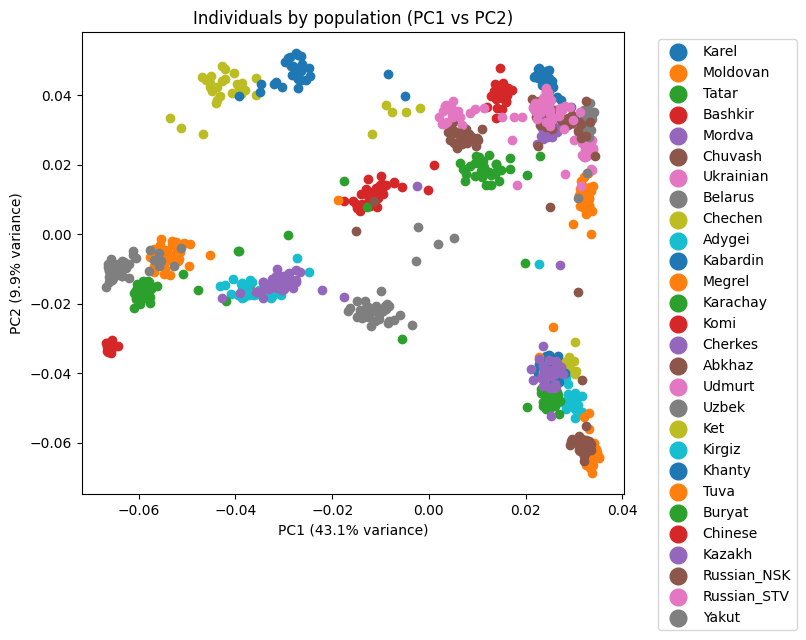

In [49]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 6))
populations = df["Population"].unique()
for pop in populations:
    sub = df[df["Population"] == pop]
    plt.scatter(
        sub["PC1"],
        sub["PC2"],
        label=pop
    )

plt.legend(markerscale=2, bbox_to_anchor=(1.05, 1), loc="upper left")
plt.xlabel(f"PC1 ({var_explained.iloc[0]*100:.1f}% variance)")
plt.ylabel(f"PC2 ({var_explained.iloc[1]*100:.1f}% variance)")
plt.title("Individuals by population (PC1 vs PC2)")
plt.show()

### Model Learning

In [64]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC


X = df[pc_cols].values
y = df["Population"].values


le = LabelEncoder()
y_enc = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.2, random_state=42, stratify=y_enc
)

models = {
    "LogisticRegression": LogisticRegression(max_iter=500),
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=42),
    "SVM": SVC(kernel="rbf", probability=True, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "NaiveBayes": GaussianNB()
}

for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring="accuracy")
    print(f"{name}: mean accuracy = {scores.mean():.3f} ± {scores.std():.3f}")


LogisticRegression: mean accuracy = 0.404 ± 0.036
RandomForest: mean accuracy = 0.856 ± 0.024
SVM: mean accuracy = 0.814 ± 0.024
KNN: mean accuracy = 0.811 ± 0.026
NaiveBayes: mean accuracy = 0.820 ± 0.027


Notice that LogisticRegression model is much less accurate, this happens because the first principal component responsible for the most variance in the dataset is outweighing other PCs. To correct it, Standard Scaler is applied.

In [65]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

for name, model in models.items():
    scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring="accuracy")
    print(f"{name}: mean accuracy = {scores.mean():.3f} ± {scores.std():.3f}")


LogisticRegression: mean accuracy = 0.793 ± 0.017
RandomForest: mean accuracy = 0.856 ± 0.024
SVM: mean accuracy = 0.811 ± 0.021
KNN: mean accuracy = 0.804 ± 0.039
NaiveBayes: mean accuracy = 0.820 ± 0.027


Accuracy (takes into account only recall) and F1-macro (averaged recall and precision) score are the highest for RandomForest model.

In [68]:
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

for name, model in models.items():
    scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring="f1_macro")
    print(f"{name}: mean F1-score = {scores.mean():.3f} ± {scores.std():.3f}")


LogisticRegression: mean F1-score = 0.790 ± 0.019
RandomForest: mean F1-score = 0.856 ± 0.017
SVM: mean F1-score = 0.799 ± 0.017
KNN: mean F1-score = 0.807 ± 0.034
NaiveBayes: mean F1-score = 0.817 ± 0.022


### Parameter Tuning

In [83]:
# tune the parameters to choose the optimal ones using stratified cross-validation

import os, joblib, numpy as np, pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import (accuracy_score, balanced_accuracy_score, f1_score,
                             log_loss, top_k_accuracy_score)

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = "balanced_accuracy"


# hyperparameter spaces
models = {
    # Linear baselines
    "LogReg":  (LogisticRegression(max_iter=5000, multi_class="multinomial", solver="lbfgs"),
                {"C": [0.3, 1, 3, 10]}),
    "SVM_rbf": (SVC(kernel="rbf", probability=True, random_state=42),
                {"C": [0.3, 1, 3, 10], "gamma": ["scale", 0.1, 0.03, 0.01]}),
    "KNN":     (KNeighborsClassifier(),
                {"n_neighbors": [5, 9, 15, 25], "weights": ["uniform", "distance"]}),
    "GaussianNB": (GaussianNB(),
                   {"var_smoothing": [1e-9, 3e-9, 1e-8, 3e-8, 1e-7]}),

    # Trees
    "RandomForest": (RandomForestClassifier(random_state=42, n_jobs=-1),
                     {"n_estimators": [200, 400],
                      "max_depth": [None, 20],
                      "min_samples_leaf": [1, 2],
                      "min_samples_split": [2, 5],
                      "max_features": ["sqrt", "log2", 0.5],
                      "class_weight": [None, "balanced_subsample"]}),

    "AdaBoost": (AdaBoostClassifier(random_state=42),
                 {"n_estimators": [200], "learning_rate": [0.5, 1.0]})
}


cv_results_list = []
best_models = {}

os.makedirs("tuned_models", exist_ok=True)

for name, (estimator, grid) in models.items():
    print(f"\n=== Tuning {name} ===")
    cache_path = f"tuned_models/{name}_best.pkl"

    """if os.path.exists(cache_path):
        best = joblib.load(cache_path)
        print("[cache] loaded best estimator")"""

    gs = GridSearchCV(estimator, grid, scoring=scoring, cv=cv,
                      n_jobs=-1, refit=True, verbose=0)
    gs.fit(X_train_scaled, y_train)
    best = gs.best_estimator_
    cv_ba = gs.best_score_
    joblib.dump(best, cache_path)
    pd.DataFrame(gs.cv_results_).to_csv(f"tuned_models/{name}_cv_results.csv", index=False)
    print("best params:", gs.best_params_, "cv Balanced Accuracy:", cv_ba)

    best_models[name] = best
    cv_results_list.append({"name": name, "cv_ba": float(cv_ba), "best": best})


cv_results_list = [d for d in cv_results_list if not np.isnan(d["cv_ba"])]
top3 = sorted(cv_results_list, key=lambda d: d["cv_ba"], reverse=True)[:3]
print("\nTop-3 by CV BA:")
for d in top3:
    print(f"  {d['name']}: CV BA={d['cv_ba']:.3f}")




=== Tuning LogReg ===


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.


best params: {'C': 0.3} cv Balanced Accuracy: 0.8123894557823128

=== Tuning SVM_rbf ===
best params: {'C': 3, 'gamma': 'scale'} cv Balanced Accuracy: 0.8260969387755104

=== Tuning KNN ===
best params: {'n_neighbors': 5, 'weights': 'uniform'} cv Balanced Accuracy: 0.8056207482993196

=== Tuning GaussianNB ===
best params: {'var_smoothing': 1e-09} cv Balanced Accuracy: 0.8313095238095236

=== Tuning RandomForest ===
best params: {'class_weight': None, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200} cv Balanced Accuracy: 0.8741666666666668

=== Tuning AdaBoost ===
best params: {'learning_rate': 1.0, 'n_estimators': 200} cv Balanced Accuracy: 0.2909353741496599

Top-3 by CV BA:
  RandomForest: CV BA=0.874
  GaussianNB: CV BA=0.831
  SVM_rbf: CV BA=0.826


## Evaluate the best model on Test Data


=== TEST metrics for RandomForest ===
Accuracy:          0.866
Balanced Accuracy: 0.874
Macro-F1:          0.875
LogLoss:           0.515
Top-2 Accuracy:    0.939


<Figure size 900x900 with 0 Axes>

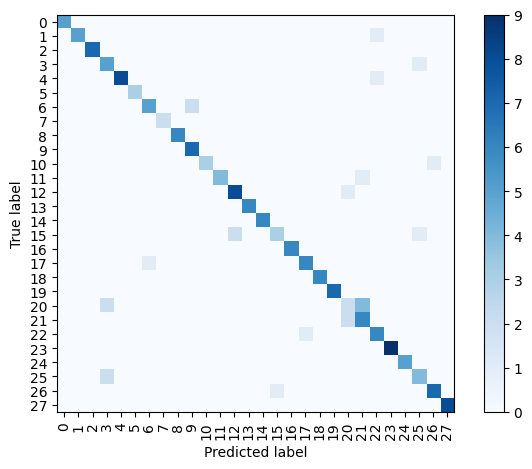


=== TEST metrics for GaussianNB ===
Accuracy:          0.816
Balanced Accuracy: 0.823
Macro-F1:          0.817
LogLoss:           1.735
Top-2 Accuracy:    0.939


<Figure size 900x900 with 0 Axes>

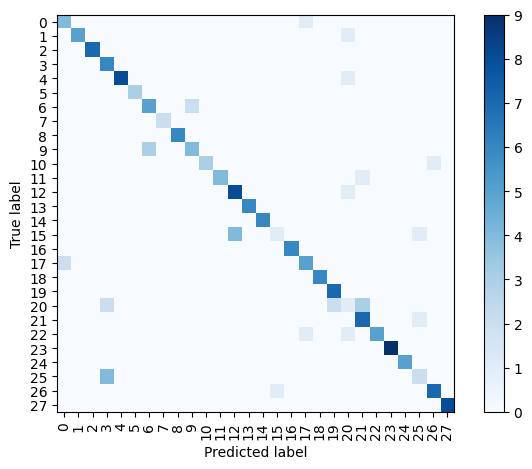


=== TEST metrics for SVM_rbf ===
Accuracy:          0.804
Balanced Accuracy: 0.809
Macro-F1:          0.803
LogLoss:           0.853
Top-2 Accuracy:    0.922


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


<Figure size 900x900 with 0 Axes>

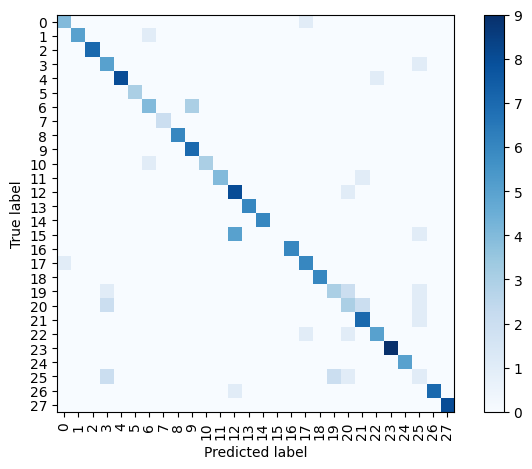

In [92]:
# --- evaluate those top-3 on TEST ---
from sklearn.metrics import (accuracy_score, balanced_accuracy_score, f1_score,
                             log_loss, top_k_accuracy_score, classification_report,
                             confusion_matrix, ConfusionMatrixDisplay)
import matplotlib.pyplot as plt

test_rows = []
for d in top3:
    name = d["name"]
    model = d["best"]

    y_pred = model.predict(X_test_scaled)               # keep the same feature scale as CV
    has_proba = hasattr(model, "predict_proba")
    y_proba = model.predict_proba(X_test_scaled) if has_proba else None

    acc  = accuracy_score(y_test, y_pred)
    bacc = balanced_accuracy_score(y_test, y_pred)
    f1m  = f1_score(y_test, y_pred, average="macro")
    ll   = log_loss(y_test, y_proba) if has_proba else np.nan
    top2 = top_k_accuracy_score(y_test, y_proba, k=2) if has_proba else np.nan

    print(f"\n=== TEST metrics for {name} ===")
    print(f"Accuracy:          {acc:.3f}")
    print(f"Balanced Accuracy: {bacc:.3f}")
    print(f"Macro-F1:          {f1m:.3f}")
    if has_proba:
        print(f"LogLoss:           {ll:.3f}")
        print(f"Top-2 Accuracy:    {top2:.3f}")

    # save report + confusion matrix for each top model
    rep = classification_report(y_test, y_pred, digits=3)
    with open(f"tuned_models/{name}_TEST_report.txt", "w") as f:
        f.write(rep)

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    plt.figure(figsize=(9,9))
    disp.plot(include_values=False, cmap="Blues", xticks_rotation=90)
    plt.tight_layout()
    plt.savefig(f"tuned_models/{name}_TEST_confusion_matrix.png", dpi=300, bbox_inches="tight")
    plt.show()
    plt.close()

    test_rows.append({
        "model": name,
        "cv_balanced_accuracy": d["cv_ba"],
        "test_accuracy": acc,
        "test_balanced_accuracy": bacc,
        "test_macro_f1": f1m,
        "test_log_loss": ll,
        "test_top2_accuracy": top2
    })



In [ ]:
top3_table = pd.DataFrame(test_rows).sort_values("test_balanced_accuracy", ascending=False)
top3_table.to_csv("tuned_models/top3_test_metrics.csv", index=False)

In [90]:
print("\nTop-3 on Test:")
print(top3_table.to_markdown(index=False, tablefmt="github"))


Top-3 on Test:
| model        |   cv_balanced_accuracy |   test_accuracy |   test_balanced_accuracy |   test_macro_f1 |   test_log_loss |   test_top2_accuracy |
|--------------|------------------------|-----------------|--------------------------|-----------------|-----------------|----------------------|
| RandomForest |               0.874167 |        0.865922 |                 0.873739 |        0.874549 |        0.515165 |             0.938547 |
| GaussianNB   |               0.83131  |        0.815642 |                 0.823228 |        0.816875 |        1.73544  |             0.938547 |
| SVM_rbf      |               0.826097 |        0.804469 |                 0.809198 |        0.802781 |        0.853293 |             0.921788 |


In [85]:
missing = set(np.unique(y_test)) - set(np.unique(y_pred))
if missing:
    print("⚠️ Эти классы модель вообще не предсказала:", missing)


⚠️ Эти классы модель вообще не предсказала: {np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(23), np.int64(24), np.int64(25), np.int64(26), np.int64(27)}


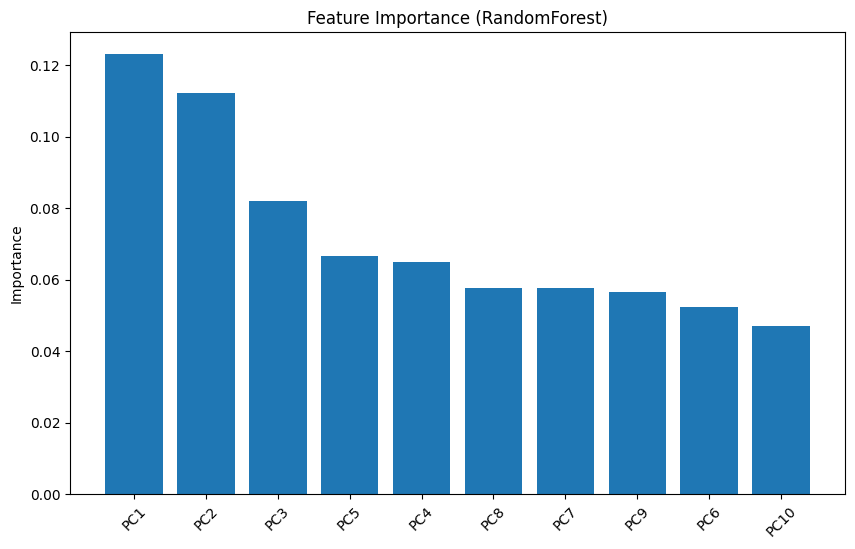

In [ ]:
 import matplotlib.pyplot as plt
import numpy as np

# feature importance из RF
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]  # сортировка по убыванию

plt.figure(figsize=(10,6))
plt.title("Feature Importance (RandomForest)")
plt.bar(range(10), importances[indices[:10]], align="center")
plt.xticks(range(10), [pc_cols[i] for i in indices[:10]], rotation=45)
plt.ylabel("Importance")
plt.show()


In [ ]:
!pip -q install umap-learn
import umap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [ ]:
# Use the same X as for models (PC1..PC20). No leakage concerns for visualization.
X_umap = df[pc_cols].to_numpy(dtype="float32")
labels = df["Group"].to_numpy()

reducer = umap.UMAP(
    n_neighbors=30,      # try 15–50
    min_dist=0.1,        # try 0.0–0.5
    n_components=2,
    metric="euclidean",
    random_state=42
)
emb = reducer.fit_transform(X_umap)  # shape: (n_samples, 2)


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.


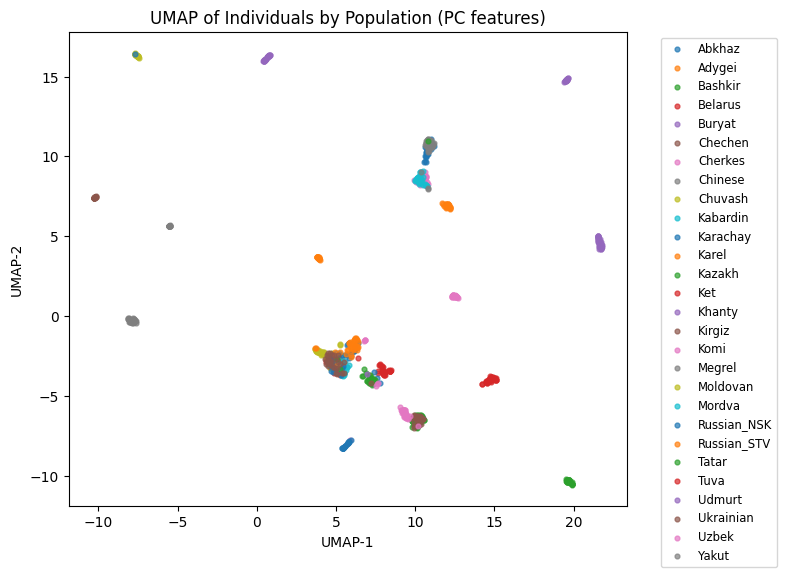

In [ ]:
plt.figure(figsize=(8,6))
for g in np.unique(labels):
    ix = labels == g
    plt.scatter(emb[ix,0], emb[ix,1], s=12, alpha=0.7, label=g)
plt.title("UMAP of Individuals by Population (PC features)")
plt.xlabel("UMAP-1"); plt.ylabel("UMAP-2")
plt.legend(bbox_to_anchor=(1.05,1), loc="upper left", fontsize="small", ncol=1)
plt.tight_layout()
plt.show()


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.


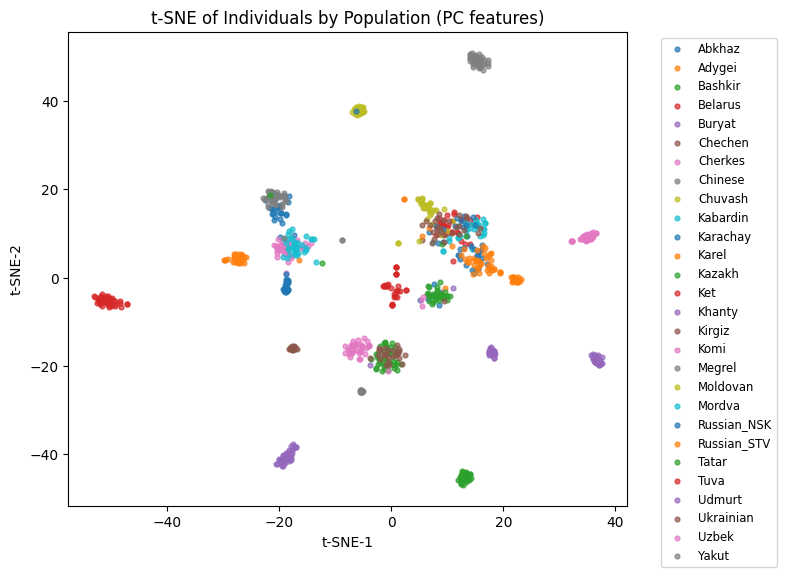

In [ ]:
# 1) Imports (sklearn already in Colab)
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt

# X = df[pc_cols].to_numpy(dtype="float32")   # you already have df and pc_cols
X_tsne_in = df[pc_cols].to_numpy(dtype="float32")
labels = df["Group"].to_numpy()

# 2) t-SNE embedding on PC features
tsne = TSNE(
    n_components=2,
    perplexity=30,     # try 20, 30, 40
    learning_rate="auto",
    init="pca",        # stable initialization
    n_iter=2000,
    random_state=42
)
emb_tsne = tsne.fit_transform(X_tsne_in)  # shape: (n_samples, 2)

# 3) Plot t-SNE (colored by population)
plt.figure(figsize=(8,6))
for g in np.unique(labels):
    idx = labels == g
    plt.scatter(emb_tsne[idx, 0], emb_tsne[idx, 1], s=12, alpha=0.7, label=g)
plt.title("t-SNE of Individuals by Population (PC features)")
plt.xlabel("t-SNE-1"); plt.ylabel("t-SNE-2")
plt.legend(bbox_to_anchor=(1.05,1), loc="upper left", fontsize="small")
plt.tight_layout()
plt.show()


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.


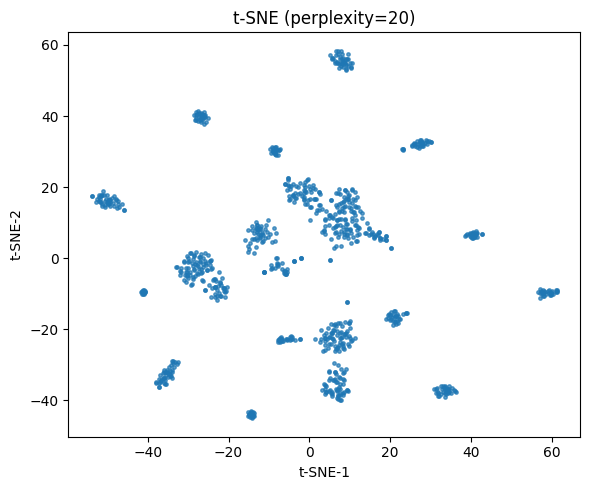

/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.


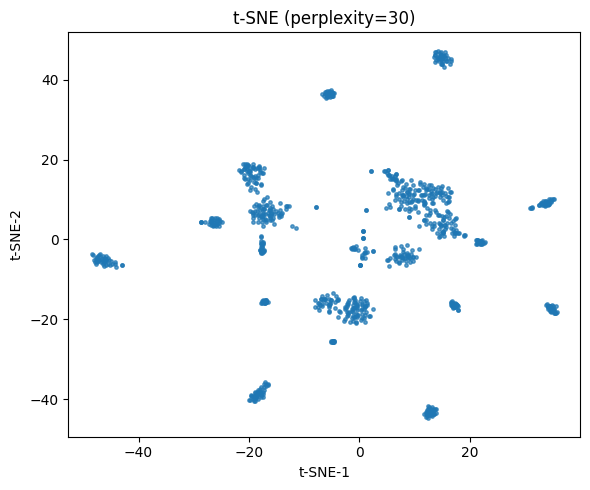

/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.


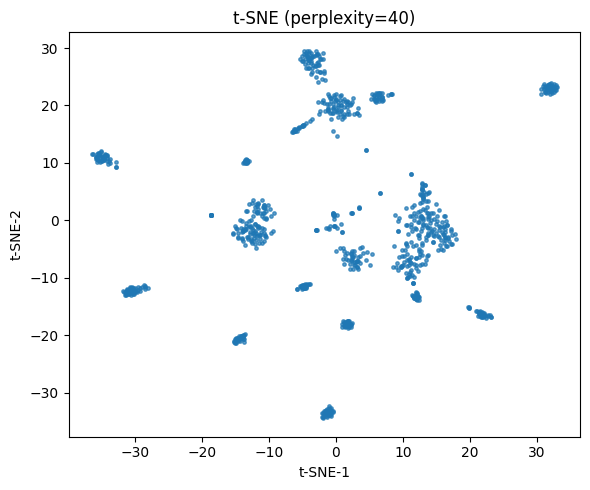

In [ ]:
for perplexity in (20, 30, 40):
    tsne = TSNE(n_components=2, perplexity=perplexity, learning_rate="auto",
                init="pca", n_iter=1500, random_state=42)
    emb = tsne.fit_transform(X_tsne_in)
    plt.figure(figsize=(6,5))
    plt.scatter(emb[:,0], emb[:,1], s=6, alpha=0.7)
    plt.title(f"t-SNE (perplexity={perplexity})")
    plt.xlabel("t-SNE-1"); plt.ylabel("t-SNE-2")
    plt.tight_layout()
    plt.show()


In [ ]:
import pandas as pd

# Fine groups observed in your data:
# ['Abkhaz','Adygei','Bashkir','Belarus','Buryat','Chechen','Cherkes','Chinese','Chuvash',
#  'Kabardin','Karachay','Karel','Kazakh','Ket','Khanty','Kirgiz','Komi','Megrel','Moldovan',
#  'Mordva','Russian_NSK','Russian_STV','Tatar','Tuva','Udmurt','Ukrainian','Uzbek','Yakut']

super_map = {
    # Slavic
    'Belarus':'Slavic','Ukrainian':'Slavic','Moldovan':'Slavic',
    'Russian_NSK':'Slavic','Russian_STV':'Slavic',

    # Turkic (Volga + Central Asia + N Caucasus Turkic)
    'Bashkir':'Turkic','Tatar':'Turkic','Kazakh':'Turkic','Kirgiz':'Turkic',
    'Uzbek':'Turkic','Karachay':'Turkic','Chuvash':'Turkic',

    # North Caucasus (non-Turkic)
    'Abkhaz':'NorthCaucasus','Adygei':'NorthCaucasus','Chechen':'NorthCaucasus',
    'Cherkes':'NorthCaucasus','Kabardin':'NorthCaucasus',

    # Finno-Ugric (Uralic)
    'Karel':'FinnoUgric','Komi':'FinnoUgric','Udmurt':'FinnoUgric','Mordva':'FinnoUgric','Khanty':'FinnoUgric',

    # Siberian / Far-East natives
    'Yakut':'Siberian','Buryat':'Siberian','Tuva':'Siberian','Ket':'Siberian',

    # East Asian
    'Chinese':'EastAsian',

    # Georgian subgroup
    'Megrel':'Georgian',
}

df['SuperGroup'] = df['Group'].map(super_map).fillna('Other')
print(df['SuperGroup'].value_counts())


SuperGroup
Turkic           231
Slavic           166
Siberian         160
FinnoUgric       145
NorthCaucasus    143
Georgian          36
EastAsian         13
Name: count, dtype: int64


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.


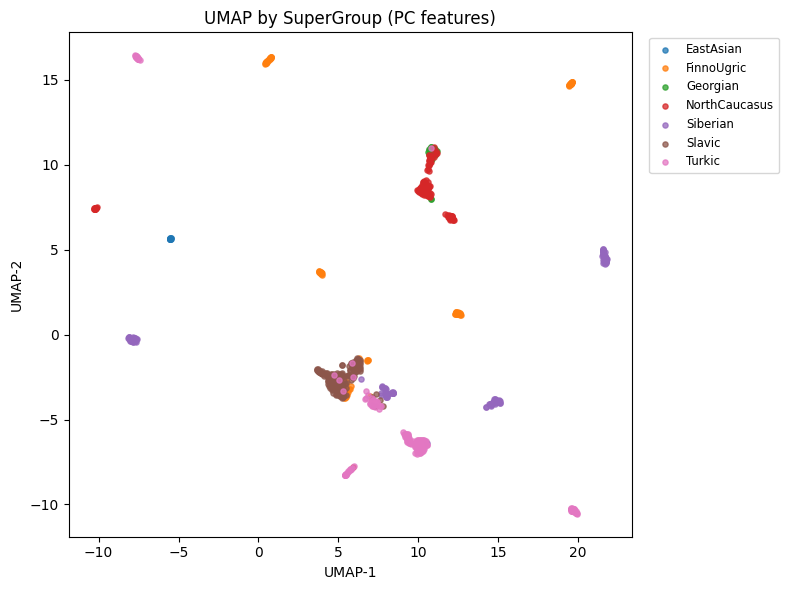

In [ ]:
import umap
import numpy as np
import matplotlib.pyplot as plt

X_umap = df[pc_cols].to_numpy(dtype='float32')
sg = df['SuperGroup'].to_numpy()

reducer = umap.UMAP(n_neighbors=30, min_dist=0.1, n_components=2, metric='euclidean', random_state=42)
emb_umap = reducer.fit_transform(X_umap)

plt.figure(figsize=(8,6))
for g in np.unique(sg):
    idx = (sg == g)
    plt.scatter(emb_umap[idx,0], emb_umap[idx,1], s=14, alpha=0.75, label=g)
plt.title("UMAP by SuperGroup (PC features)")
plt.xlabel("UMAP-1"); plt.ylabel("UMAP-2")
plt.legend(bbox_to_anchor=(1.02,1), loc="upper left", fontsize="small")
plt.tight_layout(); plt.show()


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.


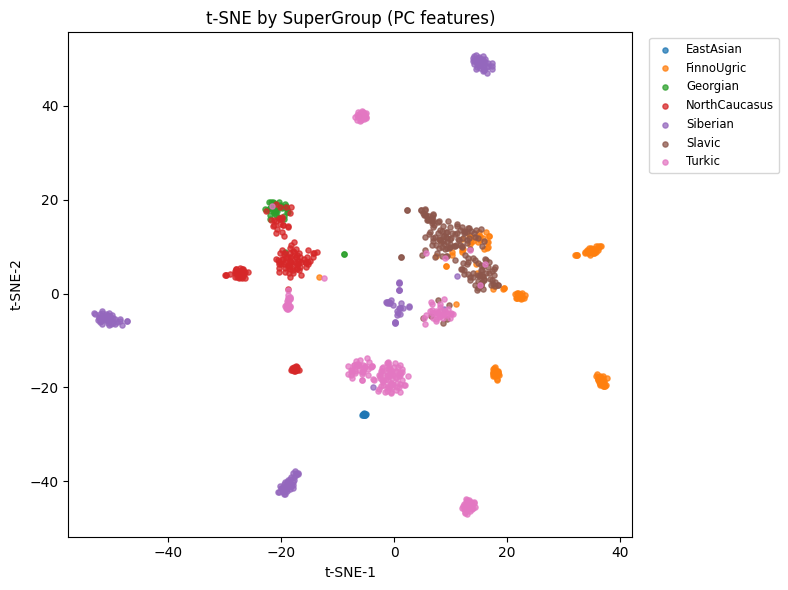

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=30, learning_rate='auto', init='pca',
            n_iter=2000, random_state=42)
emb_tsne = tsne.fit_transform(X_umap)

plt.figure(figsize=(8,6))
for g in np.unique(sg):
    idx = (sg == g)
    plt.scatter(emb_tsne[idx,0], emb_tsne[idx,1], s=14, alpha=0.75, label=g)
plt.title("t-SNE by SuperGroup (PC features)")
plt.xlabel("t-SNE-1"); plt.ylabel("t-SNE-2")
plt.legend(bbox_to_anchor=(1.02,1), loc="upper left", fontsize="small")
plt.tight_layout(); plt.show()


In [ ]:
!pip -q install xgboost lightgbm


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, classification_report

# PC features and labels
X = df[pc_cols].to_numpy(dtype="float32")
le = LabelEncoder()
y = le.fit_transform(df["Group"].to_numpy())

# Split once for final reports
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


In [ ]:
from xgboost import XGBClassifier

xgb = XGBClassifier(
    n_estimators=600,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="multi:softprob",
    eval_metric="mlogloss",
    tree_method="hist",
    random_state=42
)

xgb_acc = cross_val_score(xgb, X, y, cv=cv, scoring="accuracy", n_jobs=-1)
xgb_f1  = cross_val_score(xgb, X, y, cv=cv, scoring="f1_macro", n_jobs=-1)
print(f"XGBoost CV  | acc: {xgb_acc.mean():.3f} ± {xgb_acc.std():.3f} | F1: {xgb_f1.mean():.3f} ± {xgb_f1.std():.3f}")

# Train/test
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
print("\n=== XGBoost test report ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred_xgb):.3f} | Macro-F1: {f1_score(y_test, y_pred_xgb, average='macro'):.3f}")
print(classification_report(y_test, y_pred_xgb, target_names=le.classes_))


XGBoost CV  | acc: 0.859 ± 0.038 | F1: 0.865 ± 0.035

=== XGBoost test report ===
Accuracy: 0.844 | Macro-F1: 0.852
              precision    recall  f1-score   support

      Abkhaz       0.83      1.00      0.91         5
      Adygei       1.00      1.00      1.00         6
     Bashkir       1.00      1.00      1.00         7
     Belarus       0.71      0.83      0.77         6
      Buryat       1.00      0.89      0.94         9
     Chechen       1.00      1.00      1.00         3
     Cherkes       0.62      0.71      0.67         7
     Chinese       1.00      1.00      1.00         2
     Chuvash       1.00      1.00      1.00         6
    Kabardin       0.71      0.71      0.71         7
    Karachay       1.00      1.00      1.00         4
       Karel       1.00      0.80      0.89         5
      Kazakh       0.67      0.89      0.76         9
         Ket       1.00      1.00      1.00         6
      Khanty       1.00      1.00      1.00         6
      Kirgiz       

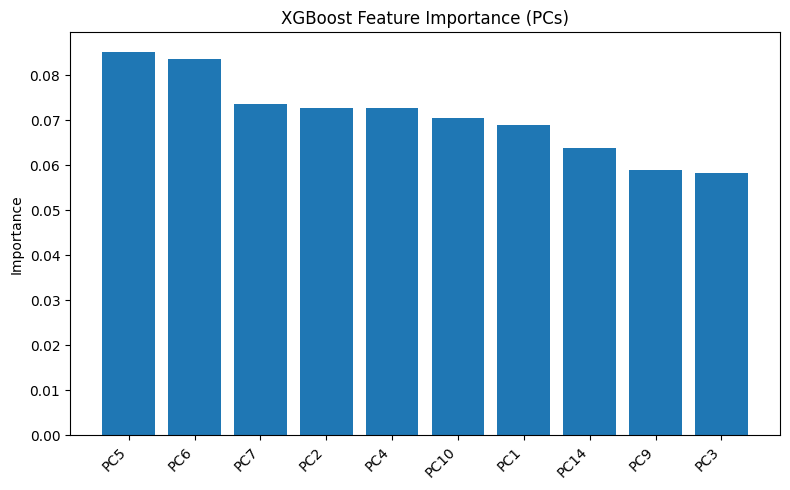

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_top_importances(model, title, topk=10):
    importances = model.feature_importances_
    idx = np.argsort(importances)[::-1][:topk]
    plt.figure(figsize=(8,5))
    plt.bar(range(topk), importances[idx])
    plt.xticks(range(topk), [pc_cols[i] for i in idx], rotation=45, ha="right")
    plt.ylabel("Importance")
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_top_importances(xgb, "XGBoost Feature Importance (PCs)")



In [ ]:
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=400, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

summary = pd.DataFrame([
    ["XGBoost",    accuracy_score(y_test, y_pred_xgb),  f1_score(y_test, y_pred_xgb,  average="macro")],

    ["RandomForest",accuracy_score(y_test, rf_pred),     f1_score(y_test, rf_pred,     average="macro")],
], columns=["Model","Test Accuracy","Test Macro-F1"])
summary


,Model,Test Accuracy,Test Macro-F1
0,XGBoost,0.843575,0.85241
1,RandomForest,0.860335,0.86862


In [ ]:
# X, y_enc, le already defined in your notebook (PC features + labels)
# If not:
# X = df[pc_cols].to_numpy(dtype="float32")
# from sklearn.preprocessing import LabelEncoder
# le = LabelEncoder(); y_enc = le.fit_transform(df["Group"].to_numpy())

from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score
import numpy as np

# Train/test split (fixed to evaluate final best model)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.2, stratify=y_enc, random_state=42
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

xgb = XGBClassifier(
    objective="multi:softprob",
    num_class=len(np.unique(y_enc)),
    tree_method="hist",          # change to "gpu_hist" if you enable GPU
    eval_metric="mlogloss",
    random_state=42,
    n_estimators=1200            # high, we’ll let learning_rate + depth regularize
)

param_distributions = {
    "learning_rate":    np.logspace(-2.2, -0.7, 12),   # ~0.006–0.2
    "max_depth":        [3,4,5,6,7,8],
    "min_child_weight": [1,2,3,5,7],
    "subsample":        [0.6,0.7,0.8,0.9,1.0],
    "colsample_bytree": [0.6,0.7,0.8,0.9,1.0],
    "gamma":            [0, 0.5, 1.0],
    "reg_alpha":        [0, 1e-3, 1e-2, 1e-1],
    "reg_lambda":       [0.5, 1.0, 1.5, 2.0]
}

search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_distributions,
    n_iter=40,                    # bump to 80+ if you have time
    scoring="f1_macro",           # robust to class imbalance
    cv=cv,
    n_jobs=-1,
    verbose=1,
    refit=True,                   # refit on full training set with best params
    random_state=42
)

search.fit(X_train, y_train)
print("Best CV macro-F1:", search.best_score_)
print("Best params:", search.best_params_)

best_xgb = search.best_estimator_
y_pred = best_xgb.predict(X_test)
print("\n=== XGBoost (tuned) — test set ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f} | Macro-F1: {f1_score(y_test, y_pred, average='macro'):.3f}")
print(classification_report(y_test, y_pred, target_names=le.classes_))


Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best CV macro-F1: 0.8533139106458435
Best params: {'subsample': 1.0, 'reg_lambda': 1.0, 'reg_alpha': 0.1, 'min_child_weight': 5, 'max_depth': 4, 'learning_rate': np.float64(0.10648114862349344), 'gamma': 1.0, 'colsample_bytree': 0.8}

=== XGBoost (tuned) — test set ===
Accuracy: 0.860 | Macro-F1: 0.866
              precision    recall  f1-score   support

      Abkhaz       0.83      1.00      0.91         5
      Adygei       1.00      1.00      1.00         6
     Bashkir       1.00      1.00      1.00         7
     Belarus       0.83      0.83      0.83         6
      Buryat       1.00      0.89      0.94         9
     Chechen       1.00      1.00      1.00         3
     Cherkes       0.60      0.43      0.50         7
     Chinese       1.00      1.00      1.00         2
     Chuvash       1.00      1.00      1.00         6
    Kabardin       0.60      0.86      0.71         7
    Karachay       1.00      1.00      